# Medianizer 2000

## Install Dependencies

In [1]:
# Add the required Packages to Pkg
using Pkg
Pkg.add("Random")
Pkg.add("DelimitedFiles")
Pkg.add("BenchmarkTools")
Pkg.add("Plots")
Pkg.add("CSV")
Pkg.add("DataFrames")


    Updating registry at `C:\Users\daily\.julia\registries\General.toml`


   Resolving package versions...


    Updating `C:\Users\daily\.julia\environments\v1.9\Project.toml`
  [9a3f8284] + Random
  No Changes to `C:\Users\daily\.julia\environments\v1.9\Manifest.toml`


   Resolving package versions...


    Updating `C:\Users\daily\.julia\environments\v1.9\Project.toml`
  [8bb1440f] + DelimitedFiles v1.9.1
  No Changes to `C:\Users\daily\.julia\environments\v1.9\Manifest.toml`


   Resolving package versions...


  No Changes to `C:\Users\daily\.julia\environments\v1.9\Project.toml`
  No Changes to `C:\Users\daily\.julia\environments\v1.9\Manifest.toml`

   Resolving package versions...


  No Changes to `C:\Users\daily\.julia\environments\v1.9\Project.toml`
  No Changes to `C:\Users\daily\.julia\environments\v1.9\Manifest.toml`

   Resolving package versions...


  No Changes to `C:\Users\daily\.julia\environments\v1.9\Project.toml`
  No Changes to `C:\Users\daily\.julia\environments\v1.9\Manifest.toml`


   Resolving package versions...


  No Changes to `C:\Users\daily\.julia\environments\v1.9\Project.toml`
  No Changes to `C:\Users\daily\.julia\environments\v1.9\Manifest.toml`


In [1]:
# Import the required Packages
using DelimitedFiles
using Random
Random.seed!(2000)
using BenchmarkTools
using Plots
using CSV
using DataFrames


## DCJ

In [2]:
# Generate the Adjacency Graph from the Genome
function AdjacencyGraph(G::Vector{Vector{Int}})
    # G is the input Genome with each chromosome represented as a separate vector

    # Initialize the AdjacencyGraph as a Vector of Vectors
    AG=Vector{Vector{Int}}()


    for chrom in G
      chrom_length=length(chrom)
      for j in 2:chrom_length
        push!(AG,[chrom[j-1],-chrom[j]])
      end
      if chrom[end]!=0
        push!(AG,[chrom[end],-chrom[1]])
      end
    end
    return AG
end


AdjacencyGraph (generic function with 1 method)

In [3]:
# Function to convert the Adjacency Graph into the Genome
function Genome(AG::Vector{Vector{Int}})
    # AG is the Adjacency Graph
    G=Vector{Vector{Int}}()
    while(length(AG)>0)
        chrom=Vector{Int}()
        # start with the first adjacency
        idx=findfirst(elt->0 in elt,AG)

        if isnothing(idx)
            idx=1
        end
        if AG[idx][2]==0
            start=AG[idx][2]
            temp=AG[idx][1]
        else
            start=AG[idx][1]
            temp=AG[idx][2]
        end
        # if the first adjacency consists of a telomere the gene is linear
        if(start==0)
            push!(chrom,start)
        end
        # Delete the adjacency after it has been used
        deleteat!(AG,idx)
        # Loop till the end of the gene
        while(start!=-temp)
            push!(chrom,-temp)
            # find the next adjacency
            i=findfirst(elt->-temp in elt,AG)
            if isnothing(i)
                break
            end
            if(AG[i][2]==-temp)
                temp=AG[i][1]
            else
                temp=AG[i][2]
            end
            deleteat!(AG,i)
        end
        push!(chrom,start)
        push!(G,chrom)
    end
    return G
end


Genome (generic function with 1 method)

In [4]:
# Function that recursively computes the length of a path
function ComputePathLength(E1::Vector{Vector{Int}}, E2::Vector{Vector{Int}}, l::Int, i::Int, select::Int)
    # E1 and E2 store the edges of the AdjacencyGraph
    # l is the current path length
    # i is the index of the current edge
    # select is the Genome number 1 or 2

    # If select is 1 use the first genome otherwise use the second
    E=(select==1) ? E2 : E1
    # Store the last visited node, to check for a cycle
    last = E[i]
    # Increment the length of the path
    l+=1
    # Delete the used edges
    deleteat!(E1,i)
    deleteat!(E2,i)
    # Find the next edge
    j = findfirst(elt -> last == elt, E)
    # If an edge exist recursively call the function with the new edge, otherwise return
    if !isnothing(j)
        last, s, l = ComputePathLength(E1, E2, l, j, 3 - select)
    else
        return last, 3 - select, l
    end
    return last, s, l
end


ComputePathLength (generic function with 1 method)

In [5]:
# Function to compute the DCJ distance between two genomes
function DCJdistance(N::Int,G1::Vector{Vector{Int}}, G2::Vector{Vector{Int}})
    # N is the number of genes
    # G1 is the first Genome
    # G2 is the second Genome

    # Get the Adjacency Graphs for both the genomes
    AG1=AdjacencyGraph(G1)
    AG2=AdjacencyGraph(G2)
    # Initialize the number of cycles and odd length paths to zero
    C=0
    I=0
    # Add the edges of the graphs to the edge vectors
    E1=Vector{Vector{Int}}()
    E2=Vector{Vector{Int}}()
    for i in 1:length(AG1)
        if(AG1[i][1]!=0)
            j=findfirst(elt->AG1[i][1] in elt, AG2)
            push!(E1,AG1[i])
            push!(E2,AG2[j])
        end
        if(AG1[i][2]!=0)
            j=findfirst(elt->AG1[i][2] in elt, AG2)
            push!(E1,AG1[i])
            push!(E2,AG2[j])
        end
    end
    # First compute the non-cyclic paths
    # All non-cyclic paths will start at an adjacency that has a telomere
    # First start with the adjacencies of genome 1 that have a telomere
    while(length(E1)>0)
        i=findfirst(elt->0 in elt,E1)
        if isnothing(i)
          break
        end
        # Store the first node of the path or cycle
        first=E1[i]
        last,s,l=ComputePathLength(E1,E2,0,i,1)
        # Check if there is a cycle present, otherwise check if the length of the path is odd
        if(s==1&&last==first)
            C=C+1
        else
            if(l%2!=0)
                I=I+1
            end
        end
    end
    # Next use the adjacencies of genome 2 that have a telomere
    while(length(E2)>0)
        i=findfirst(elt->0 in elt,E2)
        if isnothing(i)
          break
        end
        # Store the first node of the path or cycle
        first=E2[i]
        last,s,l=ComputePathLength(E1,E2,0,i,2)
        # Check if there is a cycle present, otherwise check if the length of the path is odd
        if(s==2&&last==first)
            C=C+1
        else
            if(l%2!=0)
                I=I+1
            end
        end
    end
    # Finally use all the remaining adjacencies
    while(length(E1)>0)
        # Store the first node of the path or cycle
        first=E1[1]
        last,s,l=ComputePathLength(E1,E2,0,1,1)
        # Check if there is a cycle present, otherwise check if the length of the path is odd
        if(s==1&&last==first)
            C=C+1
        else
            if(l%2!=0)
                I=I+1
            end
        end
    end
    # Compute the DCJ distance
    return Int(N-(C+div(I,2)))
end


DCJdistance (generic function with 1 method)

In [6]:
# Function to convert the first Genome into the second using DCJ operations
function DCJ(G1::Vector{Vector{Int}}, G2::Vector{Vector{Int}}, num_DCJ::Int, count_operations::Bool=false)
    # G1 is the first Genome
    # G2 is the second Genome
    # num_DCJ is the number of DCJ operations to perform
    # if count_operations is true return the number of DCJ operations performed

    # Generate the Adjacency Graphs of both the Genomes
    AG1=AdjacencyGraph(G1)
    AG2=AdjacencyGraph(G2)
    # If num_DCJ is zero return the first genome without making any changes
    if num_DCJ==0
        if count_operations==true
          return 0,G1
        else
          return G1
        end
    end
    count=0
    # Run the loop from 1 till the stop index
    # First check adjacencies that do not contain telomeres
    for i in 1:length(AG2)
        if count>=num_DCJ
          break
        end
        # For the adjacencies in the second genome that don't contain a telomere
        if(AG2[i][1]!=0&&AG2[i][2]!=0)
            # Find indices u, v in the first genome that contain the elements in the ith adjacency of the second genome
            u=findfirst(elt->AG2[i][1] in elt,AG1)
            v=findfirst(elt->AG2[i][2] in elt,AG1)
            # If u and v are different, make u equal to the ith adjacency in the second genome by performing the DCJ operation
            if(u!=v)
                count+=1
                p=AG2[i][1]
                q=AG2[i][2]
                if(AG1[u][1]!=p)
                    l=AG1[u][1]
                else
                    l=AG1[u][2]
                end
                if(AG1[v][1]!=q)
                    m=AG1[v][1]
                else
                    m=AG1[v][2]
                end
                AG1[u][1]=p
                AG1[u][2]=q
                AG1[v][1]=l
                AG1[v][2]=m
                if(p==0&&q==0)
                    deleteat!(AG1,u)
                end
                if(l==0&&m==0)
                    deleteat!(AG1,v)
                end
            end
        end
    end
    # Next check adjacencies that contain telomeres
    for i in 1:length(AG2)
      if count>=num_DCJ
        break
      end
      if(AG2[i][1]==0||AG2[i][2]==0)
        # For all the adjacencies in the second genome that contain a telomere
        if(AG2[i][1]!=0)
          p=AG2[i][1]
        else
          p=AG2[i][2]
        end
        # Find the vertex u in the first genome that contains the same element
        u=findfirst(elt->p in elt,AG1)
        if(AG1[u][1]!=p)
          l=AG1[u][1]
        else
          l=AG1[u][2]
        end
        # If vertex u is not equal to vertex i
        if(l!=0)
          count+=1
          # Perfom the DCJ operation on vertex u
          AG1[u][1]=p
          AG1[u][2]=0
          push!(AG1,[l,0])
        end
      end
    end
    # Return the genome represented by the resulting adjacency graph
    if count_operations==true
      return count,Genome(AG1)
    else
      return Genome(AG1)
    end
end


DCJ (generic function with 2 methods)

## Genetic Algorithm

In [7]:
# Function to compute the fitness score based on the DCJ distance
function Fitness(N::Int,G1::Vector{Vector{Int}}, G2::Vector{Vector{Int}}, G3::Vector{Vector{Int}}, G::Vector{Vector{Int}})
    # N is the number of Genes
    # G1, G2, G3 are the input Genomes
    # G is the candidate Median Genome

    # SBest is the best possible median score
    SBest=ceil((DCJdistance(N,G1,G2)+DCJdistance(N,G2,G3)+DCJdistance(N,G1,G3))/2)
    # S is the median score of genome G
    S=DCJdistance(N,G1,G)+DCJdistance(N,G2,G)+DCJdistance(N,G3,G)
    # FG is the fitness score of Genome G
    FG=N-(S-SBest)
    return FG
end


Fitness (generic function with 1 method)

In [8]:
# Function that generates the initial population based on the 3 Genomes
function Initialize(N::Int,G1::Vector{Vector{Int}},G2::Vector{Vector{Int}},G3::Vector{Vector{Int}},pop_size::Int)
    # N is the number of Genes
    # G1, G2, G3 are the input Genomes
    # pop_size is the Size of the Population

    # Generate the Initial Population by performing the DCJ operation on the 3 pairs of Genomes and stopping at random points in the DCJ operation
    a=div(pop_size,3)
    Population=Vector{Vector{Vector{Int}}}(undef, pop_size)
    for i in 1:a
        Population[i]=DCJ(G1,G2,rand(1:N))
    end
    for i in 1:a
        Population[i+a]=DCJ(G2,G3,rand(1:N))
    end
    for i in 1:pop_size-2*a
        Population[i+2*a]=DCJ(G1,G3,rand(1:N))
    end
    return Population
end


Initialize (generic function with 1 method)

In [9]:
# Function that generates a mutation of a genome
function Mutate(N::Int,Child::Vector{Vector{Int}}, G1::Vector{Vector{Int}}, G2::Vector{Vector{Int}}, G3::Vector{Vector{Int}})
    # N is the number of Genes
    # Child is the Genome that needs to be mutated
    # G1, G2, G3 are the input Genomes

    # Estimate the distances to each of the genomes
    d1_est=div((DCJdistance(N,G1,G2)+DCJdistance(N,G1,G3)-DCJdistance(N,G2,G3)),2)
    d2_est=div((DCJdistance(N,G1,G2)+DCJdistance(N,G2,G3)-DCJdistance(N,G1,G3)),2)
    d3_est=div((DCJdistance(N,G1,G3)+DCJdistance(N,G2,G3)-DCJdistance(N,G1,G2)),2)
    # Calculate the Actual distance of the median genome from the other genomes
    d1=DCJdistance(N,G1,Child)
    d2=DCJdistance(N,G2,Child)
    d3=DCJdistance(N,G3,Child)
    diff1=d1-d1_est
    diff2=d2-d2_est
    diff3=d3-d3_est
    # Mutate the median genome towards the genome it is furthest from
    if(diff1>=diff2&&diff1>=diff3)
        mut=DCJ(Child,G1,diff1)
    else
        if(diff2>=diff1&&diff2>=diff3)
            mut=DCJ(Child,G2,diff2)
        else
            mut=DCJ(Child,G3,diff3)
        end
    end
    return mut
end


Mutate (generic function with 1 method)

In [10]:
# Generate the Children after the crossover of two parents
function Crossover(N::Int,Parent1::Vector{Vector{Int}}, Parent2::Vector{Vector{Int}}, G1::Vector{Vector{Int}}, G2::Vector{Vector{Int}}, G3::Vector{Vector{Int}})
    # N is the number of Genes
    # Parent1, Parent2 are the two Genomes on whom the Crossover has to be performed
    # G1, G2, G3 are the input Genomes

    # Compute the fitness score for both the parents
    f1=Fitness(N,G1,G2,G3,Parent1)
    f2=Fitness(N,G1,G2,G3,Parent2)
    # Create one child by applying a random number of DCJ operations to the parent with the worse fitness score
    if(f1>f2)
        Child1=DCJ(Parent2,Parent1,rand(1:N))
        Child2=Parent1
    else
        Child1=DCJ(Parent1,Parent2,rand(1:N))
        Child2=Parent2
    end
    # Mutate both the generated children
    mut1=Mutate(N,Child1,G1,G2,G3)
    mut2=Mutate(N,Child2,G1,G2,G3)
    # Calculate the fitness scores of all the four genomes
    fc1=Fitness(N,G1,G2,G3,Child1)
    fc2=Fitness(N,G1,G2,G3,Child2)
    fmut1=Fitness(N,G1,G2,G3,mut1)
    fmut2=Fitness(N,G1,G2,G3,mut2)
    scores=[[fc1,Child1],[fc2,Child2],[fmut1,mut1],[fmut2,mut2]]
    sort!(scores)
    # return the best 2 children based on the fitness scores
    return scores[4][2], scores[3][2]
end


Crossover (generic function with 1 method)

In [11]:
# Function that eliminates duplicated Genomes from the Population
function EliminateDuplicates!(Population::Vector{Vector{Vector{Int}}})
  # Population is the Population of all Genomes, generated from the Crossover and Mutation operations

  # Start with the first Genome
  i=1
  while(i<=length(Population))
    j=i+1
    # For each other Genomes check if it is equal to the ith Genome
    while(j<=length(Population))
      # If it is equal delete it from the population
      if sameGenome(Population[i],Population[j])
        deleteat!(Population,j)
      else
        j+=1
      end
    end
    i+=1
  end
end


EliminateDuplicates! (generic function with 1 method)

In [12]:
# Function that selects best from a given population
function SelectBest(N::Int,Population::Vector{Vector{Vector{Int}}},pop_size::Int,G1::Vector{Vector{Int}},G2::Vector{Vector{Int}},G3::Vector{Vector{Int}})
    # N is the number of Genes
    # Population is the Population of Genomes generated from the crossover and mutation operations
    # pop_size is the size of the population
    # G1, G2, G3 are the input Genomes

    # Eliminate duplicates from the Population
    EliminateDuplicates!(Population)
    # Initialize vector of scores
    scores=[]
    # For each genome in the population compute the fitness score
    for i in 1:length(Population)
        fit=Fitness(N,G1,G2,G3,Population[i])
        append!(scores,[[fit,i]])
    end
    # Sort the scores in descending order
    sort!(scores, rev=true)
    # Separted the top 10% of scores from the remaining
    top_scores=scores[1:min(Int(round(0.1*pop_size)),length(Population))]
    remaining_scores=scores[1+Int(round(0.1*pop_size)):end]
    # Get the indices of the top scores and the remaining scores
    top_indices=[]
    for score in top_scores
      append!(top_indices,Int(score[2]))
    end
    remaining_indices=[]
    for score in remaining_scores
      append!(remaining_indices,Int(score[2]))
    end
    # Automatically choose the first 10 percent
    NewPopulation=Population[top_indices]
    # From the remaining population randomly choose candidate genomes
    RemainingPopulation=Population[remaining_indices]
    for i in length(NewPopulation)+1:pop_size
        if(length(RemainingPopulation)==0)
          break
        end
        if(length(RemainingPopulation)>1)
          r=rand(1:length(RemainingPopulation))
        else
          r=1
        end
        push!(NewPopulation,RemainingPopulation[r])
        deleteat!(RemainingPopulation,r)
    end
    return NewPopulation
end


SelectBest (generic function with 1 method)

In [13]:
# Function that performs the Genetic Algorithm
function GeneticAlgorithm(
    N::Int,
    G1::Vector{Vector{Int}},
    G2::Vector{Vector{Int}},
    G3::Vector{Vector{Int}},
    PopSize::Int,
    NextGenSize::Int,
    NumIter::Int,
    tol::Int=NumIter,
    store_iteration_result::Bool=false,
    output_channel::Union{Nothing, Channel}=nothing,
)
    # N is the number of Genes
    # G1, G2, G3 are the input Genomes
    # PopSize the Size of the Population
    # NextGenSize is the Size of the Generated Next Generation, should be an even number because children are generated in pairs
    # NumIter is the number of iterations
    # tol is the number of iterations for which no improvement in the best score will be tolerated

    # Initialize the algorithm
    Population=Initialize(N,G1,G2,G3,PopSize)
    # In each iteration
    iter_required=NumIter
    prev_best=0
    num=0
    NextGenSize+=1
    if store_iteration_result
      results=zeros(div(NumIter,10))
    end
    for iter in 1:NumIter
        NewPopulation=Vector{Vector{Vector{Int}}}(undef, NextGenSize)
        # The Best Genome is automatically selected in the Next Generation
        NewPopulation[1]=deepcopy(Population[1])

        # Output to UI
        if !isnothing(output_channel)
          println("Putting output $iter")
          put!(output_channel, (iter, deepcopy(Population[1])))
          println("Done putting output $iter")
        end

        j=2
        # Generate the new population by performing the crossover and mutation by choosing two random parents
        while(true)
            if(j>NextGenSize)
              break
            end
            child1,child2=Crossover(N,Population[rand(1:length(Population))],Population[rand(1:length(Population))],G1,G2,G3)
            NewPopulation[j]=child1
            j+=1
            if(j>NextGenSize)
              break
            end
            NewPopulation[j]=child2
            j+=1
        end
        # Select the best from the population
        Population=SelectBest(N,NewPopulation,PopSize,G1,G2,G3)
        curr_score=Fitness(N,G1,G2,G3,Population[1])
        if store_iteration_result&&iter%10==0
          results[div(iter,10)]=curr_score
        end
        # If the current is the best possible score return
        if curr_score==N
          iter_required=iter
          break
        end
        # If the current score has not improved after 'tol' number of iterations break
        if curr_score<=prev_best
          num+=1
          if num==tol
            iter_required=iter
            break
          end
        else
          num=0
        end
        prev_best=max(prev_best,curr_score)
    end
    if store_iteration_result&&iter_required<NumIter
      for i in div(iter_required,10)+1:div(NumIter,10)
        results[i]=N
      end
    end
    if store_iteration_result
      return Population[1],iter_required,results
    else
      return Population[1],iter_required
    end
end


GeneticAlgorithm (generic function with 3 methods)

## Genetic Algorithm for M Genomes (Generalized Median Solver)

In [14]:
# Function that generates the initial population based on M Genomes
function InitializeGeneral(N::Int,M::Int,Genomes::Vector{Vector{Vector{Int}}},pop_size::Int)
    # N is the number of Genes
    # M is the number of Input Genomes
    # Genomes is the Vector of Input Genomes
    # pop_size is the Size of the Population

    # Generate the Initial Population by performing the DCJ operation on all pairs of Genomes and stopping at random points in the DCJ operation
    num_pairs=M*(M-1)/2
    a=Int(floor(pop_size/num_pairs))
    Population=Vector{Vector{Vector{Int}}}(undef, pop_size)
    k=1
    for i in 1:M-2
      for j in i+1:M
        for _ in 1:a
          Population[k]=DCJ(Genomes[i],Genomes[j],rand(1:N))
          k+=1
        end
      end
    end
    for _ in 1:Int(pop_size-(num_pairs-1)*a)
      Population[k]=DCJ(Genomes[end-1],Genomes[end],rand(1:N))
      k+=1
    end
    return Population
end


InitializeGeneral (generic function with 1 method)

In [15]:
# Function to compute the fitness score based on the DCJ distance for the Median of M Genomes
function FitnessGeneral(N::Int,M::Int,Genomes::Vector{Vector{Vector{Int}}}, G::Vector{Vector{Int}})
    # N is the Number of Genomes
    # M is the Number of Input Genomes
    # Genomes is the Vector of Input Genomes
    # G is the Candidate Median Genome

    # SBest is the best possible median score
    SBest=0
    for i in 1:M-1
      for j in i+1:M
        SBest+=DCJdistance(N,Genomes[i],Genomes[j])
      end
    end
    SBest=ceil(SBest/(M-1))
    # S is the median score of genome G
    S=0
    for i in 1:length(Genomes)
      S+=DCJdistance(N,Genomes[i],G)
    end
    # FG is the fitness score of Genome G
    FG=N-(S-SBest)
    return FG
end


FitnessGeneral (generic function with 1 method)

In [16]:
# Function that generates a mutation of a genome in the case of Median of M Genomes
function MutateGeneral(N::Int,M::Int,Child::Vector{Vector{Int}}, Genomes::Vector{Vector{Vector{Int}}})
    # N is the Number of Genes
    # M is the Number of Input Genomes
    # Child is the Genome that has to be mutated
    # Genomes is the Vector of Input Genomes

    # Estimate the distances to each of the genomes
    # d_est[i]=(sum of distances of Genome i to all other genomes - sum of pair wise distances of all other genomes)/(M-1)
    d_est=Vector{Int}(undef,length(Genomes))
    for i in 1:M-1
      for j in i+1:M
        dist=DCJdistance(N,Genomes[i],Genomes[j])
        for k in 1:M
          if k==i||k==j
            d_est[k]+=dist
          else
            d_est[k]-=dist
          end
        end
      end
    end
    for i in 1:M
      d_est[i]=div(d_est[i],(M-1))
    end
    # Calculate the Actual distance of the median genome from the other genomes
    d=Vector{Int}(undef,M)
    for i in 1:M
      d[i]=DCJdistance(N,Genomes[i],Child)
    end
    diff=d-d_est
    # Mutate the median genome towards the genome it is furthest from
    idx=argmax(diff)
    mut=DCJ(Child,Genomes[idx],diff[idx])
    return mut
end


MutateGeneral (generic function with 1 method)

In [17]:
# Generate the Children after the crossover of two parents in the case of finding the Median of M Genomes
function CrossoverGeneral(N::Int,M::Int,Parent1::Vector{Vector{Int}}, Parent2::Vector{Vector{Int}}, Genomes::Vector{Vector{Vector{Int}}})
    # N is the Number of Genes
    # M is the Number of Input Genomes
    # Parent1, Parent2 are the two Genomes on whom the Crossover operation has to be performed
    # Genomes is the Vector of Input Genomes
    # Compute the fitness score for both the parents
    f1=FitnessGeneral(N,M,Genomes,Parent1)
    f2=FitnessGeneral(N,M,Genomes,Parent2)
    # Create one child by applying a random number of DCJ operations to the parent with the worse fitness score
    if(f1>f2)
        Child1=DCJ(Parent2,Parent1,rand(1:N))
        Child2=Parent1
    else
        Child1=DCJ(Parent1,Parent2,rand(1:N))
        Child2=Parent2
    end
    # Mutate both the generated children
    mut1=MutateGeneral(N,M,Child1,Genomes)
    mut2=MutateGeneral(N,M,Child2,Genomes)
    # Calculate the fitness scores of all the four genomes
    fc1=FitnessGeneral(N,M,Genomes,Child1)
    fc2=FitnessGeneral(N,M,Genomes,Child2)
    fmut1=FitnessGeneral(N,M,Genomes,mut1)
    fmut2=FitnessGeneral(N,M,Genomes,mut2)
    scores=[[fc1,Child1],[fc2,Child2],[fmut1,mut1],[fmut2,mut2]]
    sort!(scores)
    # return the best 2 children based on the fitness scores
    return scores[4][2], scores[3][2]
end


CrossoverGeneral (generic function with 1 method)

In [18]:
# Function that selects best from a given population in the case of finding the Median of M Genomes
function SelectBestGeneral(N::Int,M::Int,Population::Vector{Vector{Vector{Int}}},pop_size::Int,Genomes::Vector{Vector{Vector{Int}}})
    # N is the Number of Genes
    # M is the Number of Input Genomes
    # Population is the Population Generated from the Crossover and Mutation Operations
    # pop_size is the Size of the Population
    # Genomes is the Vector of Input Genomes

    # Eliminate duplicated Genomes in the Population
    EliminateDuplicates!(Population)
    # Initialize vector of scores
    scores=[]
    # For each genome in the population compute the fitness score
    for i in 1:length(Population)
        fit=FitnessGeneral(N,M,Genomes,Population[i])
        append!(scores,[[fit,i]])
    end
    # Sort the scores in descending order
    sort!(scores, rev=true)
    # Separate the top 10% of scores from the remaining scores
    if length(Population)<Int(round(0.1*pop_size))
      top_scores=scores
    else
      top_scores=scores[1:Int(round(0.1*pop_size))]
    end
    remaining_scores=scores[max(1,Int(round(0.1*pop_size))):end]
    # Get the indices of the top 10% and remaining scores
    top_indices=[]
    for score in top_scores
      append!(top_indices,Int(score[2]))
    end
    remaining_indices=[]
    for score in remaining_scores
      append!(remaining_indices,Int(score[2]))
    end
    # Automatically choose the first 10 percent
    NewPopulation=Population[top_indices]
    # From the remaining population randomly choose candidate genomes
    RemainingPopulation=Population[remaining_indices]
    for i in length(NewPopulation):pop_size
        if(length(RemainingPopulation)==0)
          break
        end
        if(length(RemainingPopulation)>1)
          r=rand(1:length(RemainingPopulation))
        else
          r=1
        end
        push!(NewPopulation,RemainingPopulation[r])
        deleteat!(RemainingPopulation,r)
    end
    return NewPopulation
end


SelectBestGeneral (generic function with 1 method)

In [19]:
# Function that performs the Genetic Algorithm in the General case of M Genomes
function GeneticAlgorithmGeneral(N::Int,M::Int,Genomes::Vector{Vector{Vector{Int}}},PopSize::Int,NextGenSize::Int,NumIter::Int,tol::Int=NumIter)
    # N is the Number of Genes
    # M is the Number of Input Genomes
    # Genomes is the Vector of Input Genomes
    # PopSize is the Size of the Population
    # NextGenSize is the Size of the Generated Next Generation
    # NumIter is the Number of Iterations
    # tol is the number of iteration for which no improvement in the best score is tolerated

    #if tol==-1
      #tol=NumIter
    #end
    # Initialize the algorithm
    Population=InitializeGeneral(N,M,Genomes,PopSize)
    # In each iteration
    iter_required=NumIter
    prev_best=0
    num=0
    for iter in 1:NumIter
        NewPopulation=Vector{Vector{Vector{Int}}}(undef, NextGenSize+1)
        NewPopulation[end]=deepcopy(Population[1])
        # Generate the new population by performing the crossover and mutation by choosing two random parents
        for i in 1:div(NextGenSize,2)
            child1,child2=CrossoverGeneral(N,M,Population[rand(1:length(Population))],Population[rand(1:length(Population))],Genomes)
            NewPopulation[2*i-1]=child1
            NewPopulation[2*i]=child2
        end
        # Select the best from the population
        Population=SelectBestGeneral(N,M,NewPopulation,PopSize,Genomes)
        curr_score=FitnessGeneral(N,M,Genomes,Population[1])
        # If the current is the best possible score return
        if curr_score==N
          iter_required=iter
          break
        end
        # If the current score has not improved after a certain number of iterations break
        if curr_score<=prev_best
          num+=1
          if num==tol
            iter_required=iter
            break
          end
        else
          num=0
        end
        prev_best=max(prev_best,curr_score)
    end
    return Population[1],iter_required
end


GeneticAlgorithmGeneral (generic function with 2 methods)

## Data Simulator

In [20]:
# Function that creates a random genome with N and a random number of chromosomes
function createGenome(N::Int,single_chrom::Bool=false)
  # N is the Number of Genes
  # if single_chrom is true create a Genome with a single chromosome

  # The genes are stored in X
  X = collect(1:N)
  # Initialize the Genome G
  G=Vector{Vector{Int}}()
  if single_chrom
    shuffle!(X)
    lin=rand([0,1])
    if lin==1
      pushfirst!(X,0)
      push!(X,0)
    end
    push!(G,X)
    return G
  end
  # Make sure that all the genes are used
  while length(X)!=0
    # Choose random start and stop positions for the chromosome
    if length(X)>1
      start_idx=rand(1:length(X)-1)
      stop_idx=rand(start_idx+1:length(X))
    else
      start_idx=1
      stop_idx=1
    end
    temp=shuffle(X[start_idx:stop_idx])
    deleteat!(X,start_idx:stop_idx)
    # If lin is 1 the chromosome is linear, otherwise it is circular
    lin=rand([0,1])
    if lin==1
      pushfirst!(temp,0)
      push!(temp,0)
    end
    push!(G,temp)
  end
  return G
end


createGenome (generic function with 2 methods)

In [21]:
# Function that checks if two genomes are the same
function sameGenome(G1::Vector{Vector{Int}},G2::Vector{Vector{Int}})
  # G1, G2 the two given Genomes

  G1=deepcopy(G1)
  G2=deepcopy(G2)
  # Check is each chromose in G2 has an equal chromosome in G1
  for j in 1:length(G2)
    # check is chromosome is linear
    if G2[j][1]==0
      # The corresponding chromosome in G1 could either be the exact copy of the chromosome in G2, or it could be the reversed complement of the chromosome in G2
      idx=findfirst(elt->elt==G2[j],G1)
      if isnothing(idx)
        reverse!(G2[j])
        G2[j]=-G2[j]
        idx=findfirst(elt->elt==G2[j],G1)
      end
      if isnothing(idx)
        return false
      end
    # Chromosome is circular
    else
      # The corresponding chromosome in G1 is could either be the exact copy of the chromosome in G2, or it could be a rotated version of it
      idx=findfirst(elt->G2[j][1] in elt,G1)
      if isnothing(idx)
        idx=findfirst(elt->-G2[j][1] in elt,G1)
        if isnothing(idx)
          return false
        else
          reverse!(G2[j])
          G2[j]=-G2[j]
          start=findfirst(elt->elt==G2[j][1],G1[idx])
        end
      else
        start=findfirst(elt->elt==G2[j][1],G1[idx])
      end
      if isnothing(start)
        return false
      end
      G2[j]=circshift(G2[j], start-1)
    end
    if G2[j]==G1[idx]
      deleteat!(G1,idx)
    end
  end
  # If all the chromosomes in G1 have been used, the two genomes are equal
  if length(G1)==0
    return true
  else
    return false
  end
end


sameGenome (generic function with 1 method)

In [22]:
# Function to perform a single random DCJ operation of a Genome
function perform_dcj(genome,single_chrom)
    # genome is the given genome
    # if single_chrom is true the DCJ operation should not add a chromosome to the Genome

    # First Generate the Adjacency Graph
    AG = AdjacencyGraph(genome)
    # Pick two random Adjacencies
    i, j = rand(1:length(AG), 2)
    # If rand(0:1) is 1 perform the DCJ operation on the two randomly picked adjacencies
    # Otherwise perform the DCJ operation on one of the randomly picked adjacencies and (0,0)
    if single_chrom||rand(0:1)==1
        temp=AG[i][2]
        AG[i][2]=AG[j][1]
        AG[j][1]=temp
        # If (0,0) is generated by the DCJ operation delete it
        if(AG[i][1]==0&&AG[i][2]==0)
            deleteat!(AG,i)
        end
        if(AG[j][1]==0&&AG[j][2]==0)
            deleteat!(AG,j)
        end
    else
        # Perfrom the DCJ operation only if both the elements in the adjacency are not zero
        if(AG[i][2]!=0&&AG[i][1]!=0)
            push!(AG,[AG[i][2],0])
            AG[i][2]=0
        end
    end
    return Genome(AG)
end


perform_dcj (generic function with 1 method)

In [23]:
# Function to randomly generate genomes from a base genome and rates of change
function simulate_genomes(n, rates, output_file,single_chrom=false, seed=nothing)
    # n is the number of genes
    # rates is a vector of rates for each generated genome
    # output_file is the file where the output of the function is stored
    # if single_chrom is true the Generated Genomes will only have one chromosome
    # seed is the seed for the random function, for reproducability

    # Set the seed if provided
    if seed !== nothing
        Random.seed!(seed)
    end

    # Randomly Generate the base Genome
    base_genome = createGenome(n,single_chrom)
    genomes = Vector{Vector{Vector{Int}}}()

    # Generate the genomes from the base_genome and given rate
    for rate in rates
        genome = copy(base_genome)
        for inversion in 1:rate
            genome=perform_dcj(genome,single_chrom)
        end
        push!(genomes, genome)
    end

    # Write to file
    open(output_file, "w") do file
        for genome in genomes
            write(file, join(genome, " "), "\n")
        end
    end

    return base_genome, genomes
end


simulate_genomes (generic function with 3 methods)

In [24]:
# Function to randomly generate genomes from a base genome, given number of Genomes
function simulate_genomesGeneral(n, m, output_file,single_chrom=false, seed=nothing)
    # n is the number of genes
    # m is the number of generated genomes
    # output_file is the file where the output of the function is stored
    # if single_chrom is true the Generated Genomes will only have one chromosome
    # seed is the seed for the random function, for reproducability

    # Set the seed if provided
    if seed !== nothing
        Random.seed!(seed)
    end

    # Randomly Generate the base Genome
    base_genome = createGenome(n,single_chrom)
    genomes = Vector{Vector{Vector{Int}}}()

    # Generate the genomes from the base_genome and given rate
    for _ in 1:m
        rate=rand(1:n)
        genome = copy(base_genome)
        for inversion in 1:rate
            genome=perform_dcj(genome,single_chrom)
        end
        push!(genomes, genome)
    end

    # Write to file
    open(output_file, "w") do file
        for genome in genomes
            write(file, join(genome, " "), "\n")
        end
    end

    return base_genome, genomes
end


simulate_genomesGeneral (generic function with 3 methods)

## Tests for DCJ

In [26]:
# Test if the Adjacency Graph and Genome functions are working correctly
N=100
num_trials=100
cor=0
for i in 1:num_trials
  # Running Adjacency Graph and the Genome should give the original genome
  G=createGenome(N)
  AG=AdjacencyGraph(G)
  newG=Genome(AG)
  if sameGenome(G,newG)
    cor+=1
  end
end
println("Percentage of correct outputs = ",(cor/num_trials)*100)


Percentage of correct outputs = 100.0


In [27]:
# Test if the DCJ function is working correctly
N=100
num_trials=100
cor=0
for i in 1:num_trials
  # The output of the DCJ Algorithm should be the same as the second genome
  G1=createGenome(N)
  G2=createGenome(N)
  G=DCJ(G1,G2,N)
  if sameGenome(G2,G)
    cor+=1
  end
end
println("Percentage of correct outputs = ",(cor/num_trials)*100)


Percentage of correct outputs = 100.0


In [28]:
# Test if the DCJdistance function is working correctly when both Genomes are the same
N=100
num_trials=100
cor=0
for i in 1:num_trials
  # The DCJ Distance between same genomes should be zero
  G1=createGenome(N)
  G2=G1
  dist=DCJdistance(N,G1,G2)
  if dist==0
    cor+=1
  end
end
println("Percentage of correct outputs = ",(cor/num_trials)*100)


Percentage of correct outputs = 100.0


In [29]:
# Test if the DCJdistance function is working correctly when the Genomes are different
N=100
num_trials=100
cor=0
for i in 1:num_trials
  # The DCJ Distance between two genomes should reduce by the number of DCJ operation performed on G1 according to the DCJ Algorithm
  G1=createGenome(N)
  G2=createGenome(N)
  dist1=DCJdistance(N,G1,G2)
  count,G3=DCJ(G1,G2,Int(rand(1:dist1)),true)
  dist2=DCJdistance(N,G3,G2)
  if dist1-dist2==count
    cor+=1
  end
end
println("Percentage of correct outputs = ",(cor/num_trials)*100)


Percentage of correct outputs = 100.0


## Tests for Genetic Algorithm

In [30]:
# Test if the Genetic Algorithm is working correctly for Genomes with one Chromosome
N=10
num_trials=100
num_iter=100
pop_size=100
next_gen_size=400
tol=100
cor=0
for i in 1:num_trials
  # Inversion rates for the three genomes
  rates = [rand(1:N), rand(1:N), rand(1:N)]
  base_genome, genomes = simulate_genomes(N, rates, "simulated_genomes.txt",true)
  out,iter=GeneticAlgorithm(N,genomes[1],genomes[2],genomes[3],pop_size,next_gen_size,num_iter,tol)
  if Fitness(N,genomes[1],genomes[2],genomes[3],out)>=Fitness(N,genomes[1],genomes[2],genomes[3],base_genome)
    cor+=1
  end
end
println("Percentage of correct outputs = ",(cor/num_trials)*100)


Percentage of correct outputs = 100.0


In [32]:
# Test if the Genetic Algorithm is working correctly for Genomes with multiple Chromosome
N=10
num_trials=100
num_iter=100
pop_size=100
next_gen_size=400
tol=100
cor=0
for i in 1:num_trials
  # Inversion rates for the three genomes
  rates = [rand(1:N), rand(1:N), rand(1:N)]
  base_genome, genomes = simulate_genomes(N, rates, "simulated_genomes.txt",false)
  out,iter=GeneticAlgorithm(N,genomes[1],genomes[2],genomes[3],pop_size,next_gen_size,num_iter,tol)
  if Fitness(N,genomes[1],genomes[2],genomes[3],out)>=Fitness(N,genomes[1],genomes[2],genomes[3],base_genome)
    cor+=1
  end
end
println("Percentage of correct outputs = ",(cor/num_trials)*100)


Percentage of correct outputs = 100.0


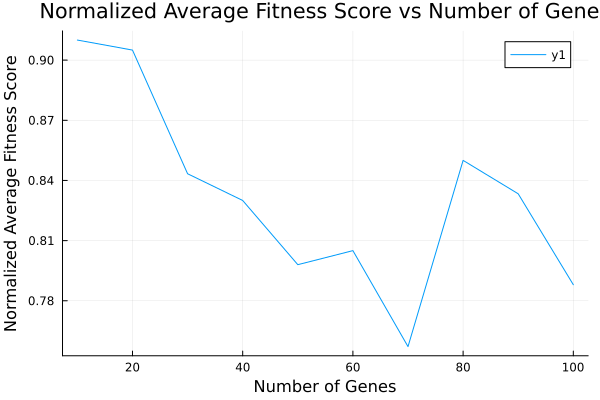

In [33]:
Num_Genes=[10,20,30,40,50,60,70,80,90,100]
Average_Fitness_Score=[]
num_iter=10
pop_size=10
next_gen_size=20
for N in Num_Genes
  fit=0
  for _ in 1:10
    base_genome, genomes = simulate_genomes(N, [rand(1:N), rand(1:N), rand(1:N)], "simulated_genomes.txt",false)
    out,iter=GeneticAlgorithm(N,genomes[1],genomes[2],genomes[3],pop_size,next_gen_size,num_iter)
    fit+=Fitness(N,genomes[1],genomes[2],genomes[3],out)
  end
  fit=fit/10
  push!(Average_Fitness_Score,fit/N)
end
plot(Num_Genes,Average_Fitness_Score,title="Normalized Average Fitness Score vs Number of Genes",xlabel="Number of Genes", ylabel="Normalized Average Fitness Score")


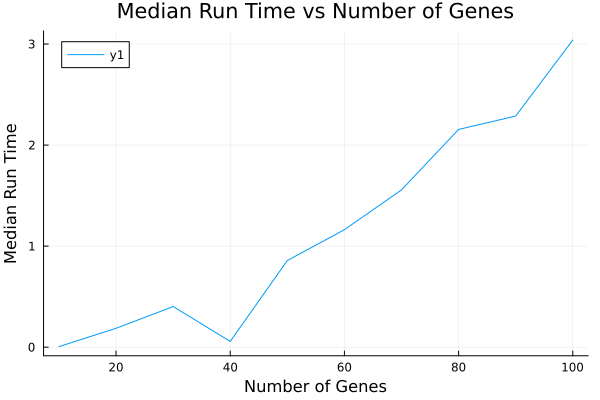

In [43]:
Num_Genes=[10,20,30,40,50,60,70,80,90,100]
Median_run_time=[]
num_iter=10
pop_size=10
next_gen_size=20
for N in Num_Genes
  base_genome, genomes = simulate_genomes(N, [rand(1:N), rand(1:N), rand(1:N)], "simulated_genomes.txt",false)
  b=@benchmark out,iter=GeneticAlgorithm($N,$genomes[1],$genomes[2],$genomes[3],$pop_size,$next_gen_size,$num_iter)
  push!(Median_run_time,median(b).time/1e9)
end
plot(Num_Genes,Median_run_time,title="Median Run Time vs Number of Genes",xlabel="Number of Genes", ylabel="Median Run Time")


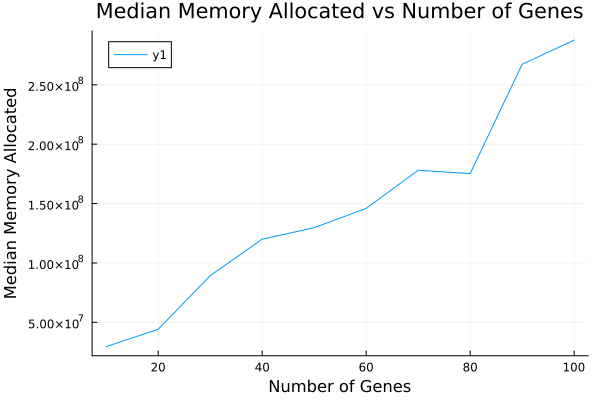

In [44]:
Num_Genes=[10,20,30,40,50,60,70,80,90,100]
Median_memory_allocated=[]
num_iter=10
pop_size=10
next_gen_size=20
for N in Num_Genes
  base_genome, genomes = simulate_genomes(N, [rand(1:N), rand(1:N), rand(1:N)], "simulated_genomes.txt",false)
  b=@benchmark out,iter=GeneticAlgorithm($N,$genomes[1],$genomes[2],$genomes[3],$pop_size,$next_gen_size,$num_iter)
  push!(Median_memory_allocated,median(b).memory)
end
plot(Num_Genes,Median_memory_allocated,title="Median Memory Allocated vs Number of Genes",xlabel="Number of Genes", ylabel="Median Memory Allocated")


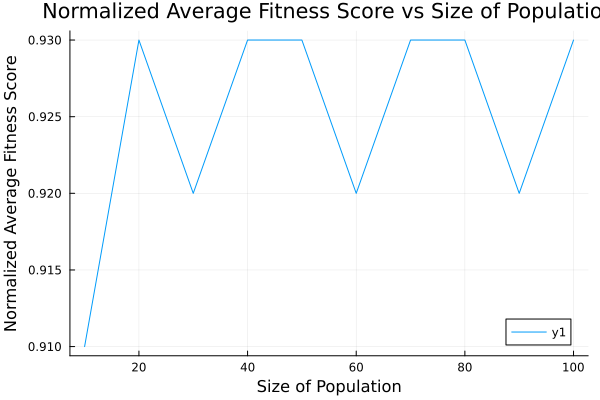

In [45]:
PopulationSize=[10,20,30,40,50,60,70,80,90,100]
Average_Fitness_Score=zeros(length(PopulationSize))
N=10
num_iter=10
for _ in 1:10
  base_genome, genomes = simulate_genomes(N, [rand(1:N), rand(1:N), rand(1:N)], "simulated_genomes.txt",false)
  for i in 1:length(PopulationSize)
    pop_size=PopulationSize[i]
    next_gen_size=2*pop_size
    out,iter=GeneticAlgorithm(N,genomes[1],genomes[2],genomes[3],pop_size,next_gen_size,num_iter)
    Average_Fitness_Score[i]+=Fitness(N,genomes[1],genomes[2],genomes[3],out)
  end
end
Average_Fitness_Score=Average_Fitness_Score/10
Average_Fitness_Score=Average_Fitness_Score/N
plot(PopulationSize,Average_Fitness_Score,title="Normalized Average Fitness Score vs Size of Population",xlabel="Size of Population", ylabel="Normalized Average Fitness Score")


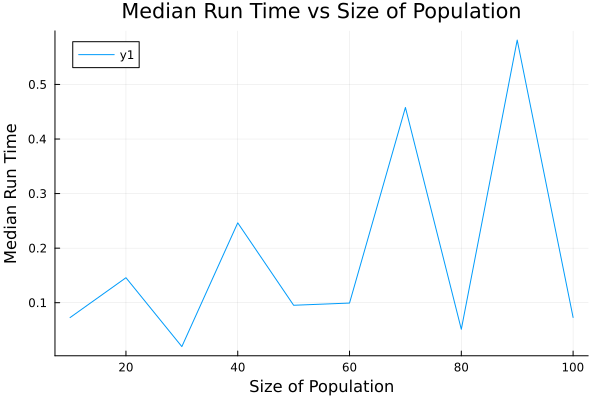

In [46]:
PopulationSize=[10,20,30,40,50,60,70,80,90,100]
Median_run_time=[]
N=10
num_iter=10
for pop_size in PopulationSize
  next_gen_size=2*pop_size
  base_genome, genomes = simulate_genomes(N, [rand(1:N), rand(1:N), rand(1:N)], "simulated_genomes.txt",false)
  b=@benchmark out,iter=GeneticAlgorithm($N,$genomes[1],$genomes[2],$genomes[3],$pop_size,$next_gen_size,$num_iter)
  push!(Median_run_time,median(b).time/1e9)
end
plot(PopulationSize,Median_run_time,title="Median Run Time vs Size of Population",xlabel="Size of Population", ylabel="Median Run Time")


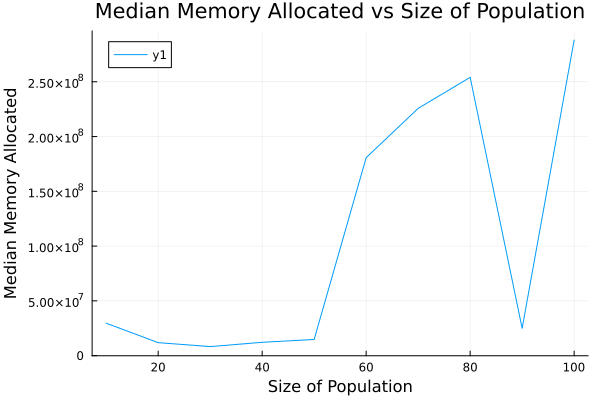

In [47]:
PopulationSize=[10,20,30,40,50,60,70,80,90,100]
Median_memory_allocated=[]
N=10
num_iter=10
for pop_size in PopulationSize
  next_gen_size=2*pop_size
  base_genome, genomes = simulate_genomes(N, [rand(1:N), rand(1:N), rand(1:N)], "simulated_genomes.txt",false)
  b=@benchmark out,iter=GeneticAlgorithm($N,$genomes[1],$genomes[2],$genomes[3],$pop_size,$next_gen_size,$num_iter)
  push!(Median_memory_allocated,median(b).memory)
end
plot(PopulationSize,Median_memory_allocated,title="Median Memory Allocated vs Size of Population",xlabel="Size of Population", ylabel="Median Memory Allocated")


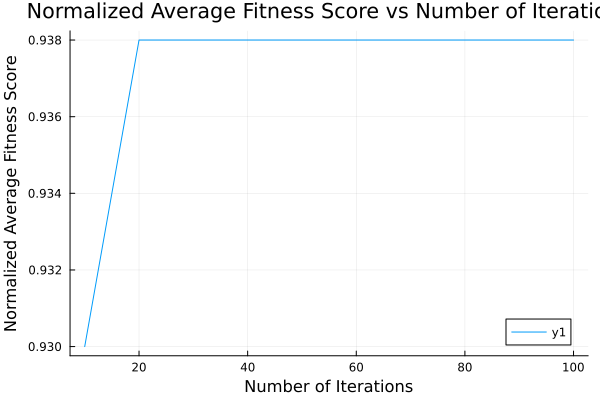

In [48]:
Iterations=[10,20,30,40,50,60,70,80,90,100]
Average_Fitness_Score=zeros(length(Iterations))
N=10
pop_size=10
next_gen_size=20
for _ in 1:100
  base_genome, genomes = simulate_genomes(N, [rand(1:N), rand(1:N), rand(1:N)], "simulated_genomes.txt",false)
  num_iter=Iterations[end]
  out,iter,results=GeneticAlgorithm(N,genomes[1],genomes[2],genomes[3],pop_size,next_gen_size,num_iter,num_iter,true)
  Average_Fitness_Score+=results
end
Average_Fitness_Score=Average_Fitness_Score/100
Average_Fitness_Score=Average_Fitness_Score/N
plot(Iterations,Average_Fitness_Score,title="Normalized Average Fitness Score vs Number of Iterations",xlabel="Number of Iterations", ylabel="Normalized Average Fitness Score")


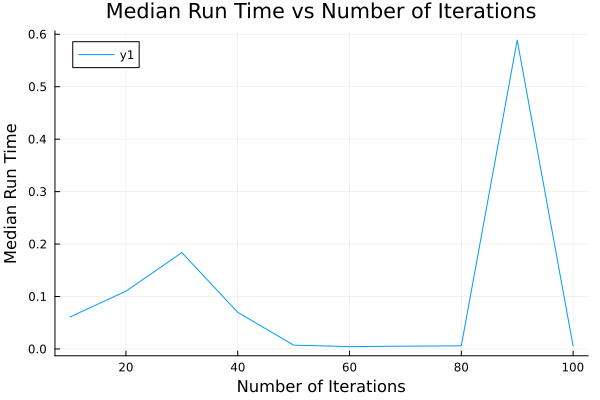

In [49]:
Iterations=[10,20,30,40,50,60,70,80,90,100]
Median_run_time=[]
N=10
pop_size=10
next_gen_size=20
for num_iter in Iterations
  base_genome, genomes = simulate_genomes(N, [rand(1:N), rand(1:N), rand(1:N)], "simulated_genomes.txt",false)
  b=@benchmark out,iter=GeneticAlgorithm($N,$genomes[1],$genomes[2],$genomes[3],$pop_size,$next_gen_size,$num_iter)
  push!(Median_run_time,median(b).time/1e9)
end
plot(Iterations,Median_run_time,title="Median Run Time vs Number of Iterations",xlabel="Number of Iterations", ylabel="Median Run Time")


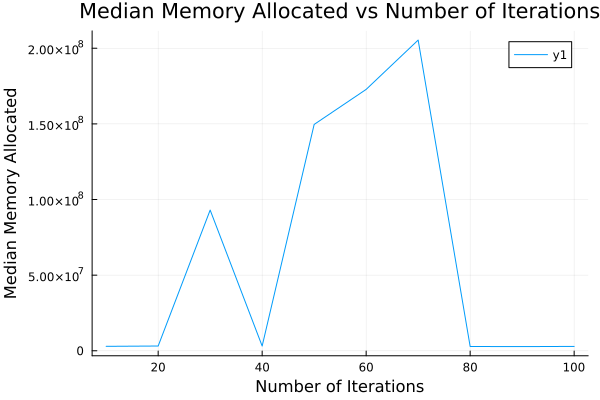

In [50]:
Iterations=[10,20,30,40,50,60,70,80,90,100]
Median_memory_allocated=[]
N=10
pop_size=10
next_gen_size=20
for num_iter in Iterations
  base_genome, genomes = simulate_genomes(N, [rand(1:N), rand(1:N), rand(1:N)], "simulated_genomes.txt",false)
  b=@benchmark out,iter=GeneticAlgorithm($N,$genomes[1],$genomes[2],$genomes[3],$pop_size,$next_gen_size,$num_iter)
  push!(Median_memory_allocated,median(b).memory)
end
plot(Iterations,Median_memory_allocated,title="Median Memory Allocated vs Number of Iterations",xlabel="Number of Iterations", ylabel="Median Memory Allocated")


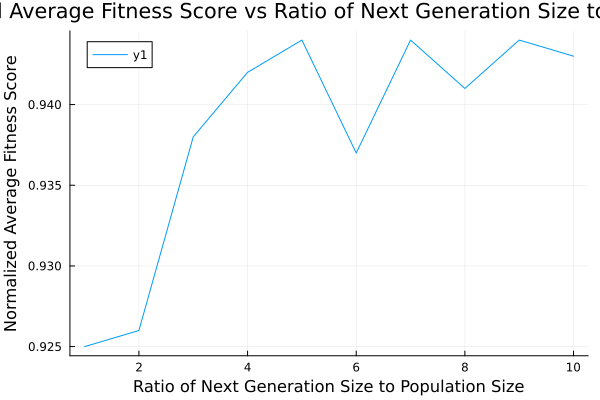

In [51]:
Ratio=[1,2,3,4,5,6,7,8,9,10]
Average_Fitness_Score=zeros(length(Iterations))
N=10
pop_size=10
num_iter=10
for _ in 1:100
  base_genome, genomes = simulate_genomes(N, [rand(1:N), rand(1:N), rand(1:N)], "simulated_genomes.txt",false)
  for i in 1:length(Ratio)
    next_gen_size=Ratio[i]*pop_size
    out,iter=GeneticAlgorithm(N,genomes[1],genomes[2],genomes[3],pop_size,next_gen_size,num_iter)
    Average_Fitness_Score[i]+=Fitness(N,genomes[1],genomes[2],genomes[3],out)
  end
end
Average_Fitness_Score=Average_Fitness_Score/100
Average_Fitness_Score=Average_Fitness_Score/N
plot(Ratio,Average_Fitness_Score,title="Normalized Average Fitness Score vs Ratio of Next Generation Size to Population Size",xlabel="Ratio of Next Generation Size to Population Size", ylabel="Normalized Average Fitness Score")


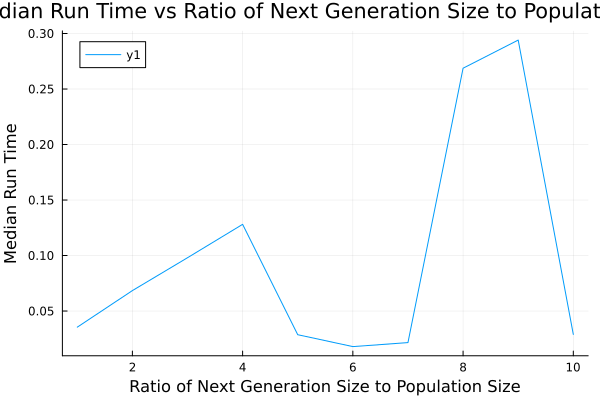

In [52]:
Ratio=[1,2,3,4,5,6,7,8,9,10]
Median_run_time=[]
N=10
pop_size=10
num_iter=10
for r in Ratio
  next_gen_size=r*pop_size
  base_genome, genomes = simulate_genomes(N, [rand(1:N), rand(1:N), rand(1:N)], "simulated_genomes.txt",false)
  b=@benchmark out,iter=GeneticAlgorithm($N,$genomes[1],$genomes[2],$genomes[3],$pop_size,$next_gen_size,$num_iter)
  push!(Median_run_time,median(b).time/1e9)
end
plot(Ratio,Median_run_time,title="Median Run Time vs Ratio of Next Generation Size to Population Size",xlabel="Ratio of Next Generation Size to Population Size", ylabel="Median Run Time")


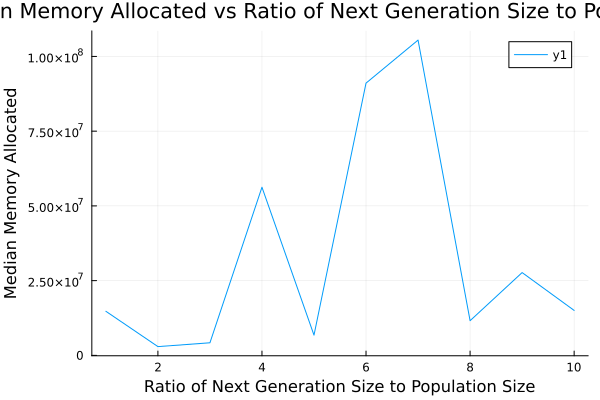

In [53]:
Ratio=[1,2,3,4,5,6,7,8,9,10]
Median_memory_allocated=[]
N=10
pop_size=10
num_iter=10
for r in Ratio
  next_gen_size=r*pop_size
  base_genome, genomes = simulate_genomes(N, [rand(1:N), rand(1:N), rand(1:N)], "simulated_genomes.txt",false)
  b=@benchmark out,iter=GeneticAlgorithm($N,$genomes[1],$genomes[2],$genomes[3],$pop_size,$next_gen_size,$num_iter)
  push!(Median_memory_allocated,median(b).memory)
end
plot(Ratio,Median_memory_allocated,title="Median Memory Allocated vs Ratio of Next Generation Size to Population Size",xlabel="Ratio of Next Generation Size to Population Size", ylabel="Median Memory Allocated")


## Tests for Genetic Algorithm with M Genomes

In [54]:
# Test if the Genetic Algorithm is working correctly for Genomes with one Chromosome
N=10
num_trials=10
num_iter=100
pop_size=50
next_gen_size=100
tol=100
cor=0
for i in 1:num_trials
  # Inversion rates for the nine genomes
  rates = [rand(1:N), rand(1:N), rand(1:N),rand(1:N), rand(1:N), rand(1:N),rand(1:N), rand(1:N), rand(1:N)]
  base_genome, genomes = simulate_genomes(N, rates, "simulated_genomes.txt",true)
  out,iter=GeneticAlgorithmGeneral(N,9,genomes,pop_size,next_gen_size,num_iter,tol)
  if FitnessGeneral(N,9,genomes,out)>=FitnessGeneral(N,9,genomes,base_genome)
    cor+=1
  end
end
println("Percentage of correct outputs = ",(cor/num_trials)*100)


Percentage of correct outputs = 100.0


In [55]:
# Test if the Genetic Algorithm is working correctly for Genomes with multiple Chromosome
N=10
num_trials=10
num_iter=100
pop_size=50
next_gen_size=100
tol=100
cor=0
for i in 1:num_trials
  # Inversion rates for the nine genomes
  rates = [rand(1:N), rand(1:N), rand(1:N),rand(1:N), rand(1:N), rand(1:N),rand(1:N), rand(1:N), rand(1:N)]
  base_genome, genomes = simulate_genomes(N, rates, "simulated_genomes.txt",false)
  out,iter=GeneticAlgorithmGeneral(N,9,genomes,pop_size,next_gen_size,num_iter,tol)
  if FitnessGeneral(N,9,genomes,out)>=FitnessGeneral(N,9,genomes,base_genome)
    cor+=1
  end
end
println("Percentage of correct outputs = ",(cor/num_trials)*100)


Percentage of correct outputs = 100.0


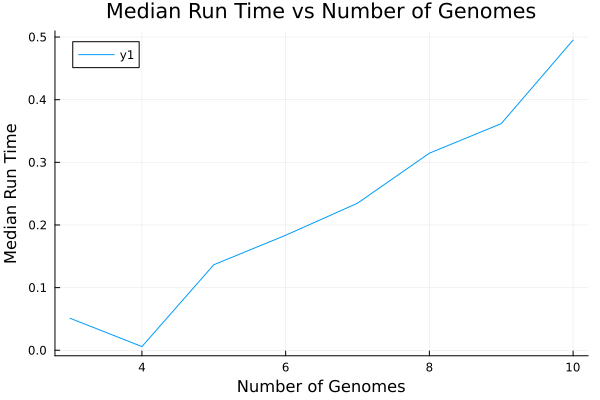

In [56]:
Num_Genomes=[3,4,5,6,7,8,9,10]
N=10
Median_run_time=[]
num_iter=10
pop_size=10
next_gen_size=20
for M in Num_Genomes
  base_genome, genomes = simulate_genomesGeneral(N, M, "simulated_genomes.txt",false)
  b=@benchmark out,iter=GeneticAlgorithmGeneral($N,$M,$genomes,$pop_size,$next_gen_size,$num_iter)
  push!(Median_run_time,median(b).time/1e9)
end
plot(Num_Genomes,Median_run_time,title="Median Run Time vs Number of Genomes",xlabel="Number of Genomes", ylabel="Median Run Time")


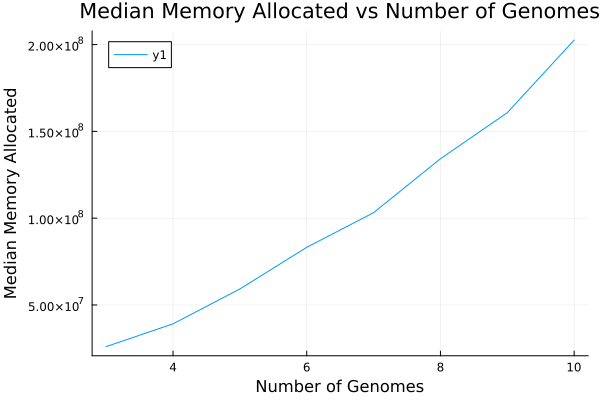

In [57]:
Num_Genomes=[3,4,5,6,7,8,9,10]
N=10
Median_memory_allocated=[]
num_iter=10
pop_size=10
next_gen_size=20
for M in Num_Genomes
  base_genome, genomes = simulate_genomesGeneral(N, M, "simulated_genomes.txt",false)
  b=@benchmark out,iter=GeneticAlgorithmGeneral($N,$M,$genomes,$pop_size,$next_gen_size,$num_iter)
  push!(Median_memory_allocated,median(b).memory)
end
plot(Num_Genomes,Median_memory_allocated,title="Median Memory Allocated vs Number of Genomes",xlabel="Number of Genomes", ylabel="Median Memory Allocated")


## Real World Data

In [25]:
# Generate permutations from Drosophila annotation data
cd(@__DIR__)

# Function to read the CSV file and process it
function process_csv(file_path::String)
    # file_path is the file path to the CSV file containing the ortolog information

    # Read the CSV file
    df = CSV.read(file_path, DataFrame)

    # Add a unique identifier to each row
    df[!, :OrthologID] = 1:nrow(df)

    # Get chromosome columns
    chromosome_cols = [name for name in names(df) if occursin("Chromosome", String(name))]

    # Group data by the combination of chromosomes to represent non-recombined chromosome fragments
    grouped = groupby(df, chromosome_cols)

    # Create separate tables for each chromosome combination, sort array by table size, and each table by D. melanogaster start position
    tables = sort([sort(subgroup[:, Not(chromosome_cols)], :Dmelanogaster_Start) for subgroup in grouped], by=x -> nrow(x), rev=true)

    return tables
end


process_csv (generic function with 1 method)

In [26]:
# Function to print ortholog group counts for the top chromosome fragments
function print_top_group_counts(tables::Array{DataFrame,1})
    # tables is the output of the process_csv() function containing the grouped ortholog data

    num_tables = length(tables)
    num_to_display = min(num_tables, 50)

    println("Ortholog Group Counts for the Top ", num_to_display, " Chromosome Fragments:")
    for i in 1:num_to_display
        println("Fragment ", i, ": ", nrow(tables[i]), " ortholog groups")
    end
end


print_top_group_counts (generic function with 1 method)

In [27]:
# Function to create a dictionary of signed permutations grouped by species
function create_permutations(tables::Array{DataFrame,1}, min_ortholog_groups::Int=0)
    # tables is the output of the process_csv() function containing the grouped ortholog data
    # min_ortholog_groups is the minimum number of ortholog groups a chromosome fragment must contain to be included in the final permutation set

    species_permutations = Dict()

    for (table_idx, table) in enumerate(tables)
        # Skip tables with fewer ortholog groups than the specified threshold
        if nrow(table) < min_ortholog_groups
            continue
        end

        for col in names(table)
            if occursin("_Gene", col)
                species = split(col, "_")[1]
                start_col = species * "_Start"
                strand_col = species * "_Strand"

                # Sort based on start positions
                sorted_genes = sortperm(table[!, start_col])

                # Determine sign based on strand and use unique numbering for genes on each chromosome fragment
                signed_perm = [table[i, strand_col] == "+" ? table[i, :OrthologID] : -table[i, :OrthologID] for i in sorted_genes]

                # Update the species_permutations dictionary
                if !haskey(species_permutations, species)
                    species_permutations[species] = []
                end
                push!(species_permutations[species], signed_perm)
            end
        end
    end

    return species_permutations
end


create_permutations (generic function with 2 methods)

In [34]:
# Create ortholog group tables based on chromosome combinations
tables = process_csv("ortholog_data_final_sorted.csv")

# Print ortholog group counts for the top groups
print_top_group_counts(tables)

# Create signed permutations for each species in each table
species_permutations = create_permutations(tables, 50)

#println(species_permutations["Dmelanogaster"][1])


Ortholog Group Counts for the Top 50 Chromosome Fragments:
Fragment 1: 728 ortholog groups
Fragment 2: 539 ortholog groups
Fragment 3: 193 ortholog groups
Fragment 4: 186 ortholog groups
Fragment 5: 176 ortholog groups
Fragment 6: 158 ortholog groups
Fragment 7: 153 ortholog groups
Fragment 8: 133 ortholog groups
Fragment 9: 126 ortholog groups
Fragment 10: 114 ortholog groups
Fragment 11: 103 ortholog groups
Fragment 12: 102 ortholog groups
Fragment 13: 92 ortholog groups
Fragment 14: 79 ortholog groups
Fragment 15: 60 ortholog groups
Fragment 16: 60 ortholog groups
Fragment 17: 57 ortholog groups
Fragment 18: 57 ortholog groups
Fragment 19: 54 ortholog groups
Fragment 20: 40 ortholog groups
Fragment 21: 39 ortholog groups
Fragment 22: 35 ortholog groups
Fragment 23: 28 ortholog groups
Fragment 24: 26 ortholog groups
Fragment 25: 21 ortholog groups
Fragment 26: 16 ortholog groups
Fragment 27: 15 ortholog groups
Fragment 28: 14 ortholog groups
Fragment 29: 13 ortholog groups
Fragment 3

Dict{Any, Any} with 9 entries:
  "Dmelanogaster" => Any[[1436, -1094, 1544, 1195, -1588, 1135, 1456, -1320, 13…
  "Dsimulans"     => Any[[1436, -1094, 1544, 1195, -1588, 1135, 1456, -1320, 13…
  "Dyakuba"       => Any[[1436, -1094, 1544, 1195, -1588, 1135, -1307, 1572, 16…
  "Dsantomea"     => Any[[1436, -1094, 1544, 1195, -1588, 1135, -1307, 1572, 16…
  "Dananassae"    => Any[[1609, 1084, 1684, 1558, 1556, -1396, 1143, -1796, -17…
  "Dsuzukii"      => Any[[1436, -1094, 1544, 1195, -1588, 1135, 1456, -1320, 13…
  "Dsechellia"    => Any[[1436, -1094, 1544, 1195, -1588, 1135, 1456, -1320, 13…
  "Dmauritiana"   => Any[[1436, -1094, 1544, 1195, -1588, 1135, 1456, -1320, 13…
  "Dmiranda"      => Any[[1732, -1230, -1407, -1459, -1638, 1219, -1676, 1238, …

In [37]:
# Test the Genetic Algorithm on 3 species with one chromosome fragment
out,i=GeneticAlgorithm(length(species_permutations["Dmelanogaster"][1]),[species_permutations["Dmelanogaster"][1]],[species_permutations["Dsimulans"][1]],[species_permutations["Dyakuba"][1]],10,20,100)
Fitness(length(species_permutations["Dmelanogaster"][1]),[species_permutations["Dmelanogaster"][1]],[species_permutations["Dsimulans"][1]],[species_permutations["Dyakuba"][1]],out)


727.0

In [46]:
# Test the Genetic Algorithm on 9 species with one chromosome fragment
out,i=GeneticAlgorithmGeneral(length(species_permutations["Dmelanogaster"][1]),9,[[species_permutations["Dmelanogaster"][1]],[species_permutations["Dsimulans"][1]],[species_permutations["Dyakuba"][1]],[species_permutations["Dsantomea"][1]],[species_permutations["Dananassae"][1]],[species_permutations["Dsuzukii"][1]],[species_permutations["Dsechellia"][1]],[species_permutations["Dmauritiana"][1]],[species_permutations["Dmiranda"][1]]],10,20,10)
FitnessGeneral(length(species_permutations["Dmelanogaster"][1]),9,[[species_permutations["Dmelanogaster"][1]],[species_permutations["Dsimulans"][1]],[species_permutations["Dyakuba"][1]],[species_permutations["Dsantomea"][1]],[species_permutations["Dananassae"][1]],[species_permutations["Dsuzukii"][1]],[species_permutations["Dsechellia"][1]],[species_permutations["Dmauritiana"][1]],[species_permutations["Dmiranda"][1]]],out)


707.0

In [45]:
# Test Genetic Algorithm with 3 species having 2 chromosome fragments
out,i=GeneticAlgorithm((length(species_permutations["Dmelanogaster"][1])+length(species_permutations["Dmelanogaster"][2])),[species_permutations["Dmelanogaster"][1],species_permutations["Dmelanogaster"][2]],[species_permutations["Dsimulans"][1],species_permutations["Dsimulans"][2]],[species_permutations["Dyakuba"][1],species_permutations["Dyakuba"][2]],10,20,10)
Fitness((length(species_permutations["Dmelanogaster"][1])+length(species_permutations["Dmelanogaster"][2])),[species_permutations["Dmelanogaster"][1],species_permutations["Dmelanogaster"][2]],[species_permutations["Dsimulans"][1],species_permutations["Dsimulans"][2]],[species_permutations["Dyakuba"][1],species_permutations["Dyakuba"][2]],out)


1265.0

In [58]:
out


2-element Vector{Vector{Int64}}:
 [4, -5, 6, 7, -8, 9, 10, -11, 12, 13  …  -721, 722, -723, -724, -725, -726, -727, 1, -2, 3]
 [732, 733, -734, 735, -736, 737, 738, -739, -740, 741  …  915, -916, 917, 918, 919, 920, -921, 729, -730, -731]

## Rainbow GUI

### Install dependencies

In [ ]:
using Pkg
Pkg.add("Gtk")
Pkg.add("Graphics")

using Gtk, Graphics


### Define colors

In [ ]:
# Returns a color sampled from a smooth, perceputally uniform rainbow ranging
# from 0.0 to 1.0
#
# Uses a 5th-order polynomial approximation of Turbo
# https://blog.research.google/2019/08/turbo-improved-rainbow-colormap-for.html
# modified from https://observablehq.com/@mbostock/turbo
function get_rainbow_color(x)
    x = max(0, min(1, x));
    return (
      (34.61 + x * (1172.33 - x * (10793.56 - x * (33300.12 - x * (38394.49 - x * 14825.05))))) / 255.0,
      (23.31 + x * (557.33 + x * (1225.33 - x * (3574.96 - x * (1073.77 + x * 707.56))))) / 255.0,
      (27.2 + x * (3211.1 - x * (15327.97 - x * (27814 - x * (22569.18 - x * 6838.66))))) / 255.0,
    )
end

# Returns a discrete color for each `n` from 1 to 22 (after that it repeats)
#
# Stolen shamelessly from https://sashamaps.net/docs/resources/20-colors/
function get_discrete_color(n)
    local colormap = [
        (0.9019607843137255, 0.09803921568627451, 0.29411764705882354),
        (0.23529411764705882, 0.7058823529411765, 0.29411764705882354),
        (1.0, 0.8823529411764706, 0.09803921568627451),
        (0.2627450980392157, 0.38823529411764707, 0.8470588235294118),
        (0.9607843137254902, 0.5098039215686274, 0.19215686274509805),
        (0.5686274509803921, 0.11764705882352941, 0.7058823529411765),
        (0.27450980392156865, 0.9411764705882353, 0.9411764705882353),
        (0.9411764705882353, 0.19607843137254902, 0.9019607843137255),
        (0.7372549019607844, 0.9647058823529412, 0.047058823529411764),
        (0.9803921568627451, 0.7450980392156863, 0.7450980392156863),
        (0.0, 0.5019607843137255, 0.5019607843137255),
        (0.9019607843137255, 0.7450980392156863, 1.0),
        (0.6039215686274509, 0.38823529411764707, 0.1411764705882353),
        (1.0, 0.9803921568627451, 0.7843137254901961),
        (0.5019607843137255, 0.0, 0.0),
        (0.6666666666666666, 1.0, 0.7647058823529411),
        (0.5019607843137255, 0.5019607843137255, 0.0),
        (1.0, 0.8470588235294118, 0.6941176470588235),
        (0.0, 0.0, 0.4588235294117647),
        (0.5019607843137255, 0.5019607843137255, 0.5019607843137255),
        (1.0, 1.0, 1.0),
        (0.0, 0.0, 0.0),
    ]
    return colormap[(n-1) % 22 + 1]
end


### Display settings

In [ ]:
# Height of idiogram display as a portion of the whole rainbow display for a chromosome
IDIOGRAM_HEIGHT = 0.3

# Padding between chromosomes, in pixels
CHROMOSOME_PADDING = 5


### Drawing functions

In [ ]:
# Draws a rectangle with color `color` at size `(x, y)` with size `(w, h)`.
function draw_colored_rect!(c :: GtkCanvas, color :: Tuple{Float64, Float64, Float64}, x, y, w, h)
    ctx = getgc(c)

    r, g, b = color

    # Round X positions
    x1 = round(x)
    x2 = round(x + w)

    rectangle(ctx, x1, y, x2-x1, h)
    set_source_rgb(ctx, r, g, b)
    fill(ctx)
end

# Draws a rainbow plot representing the signed permutation `seq` relative to
# `gene_origins`, which maps gene number to a tuple `(chromosome_index,
# index_within_chromosome, chromosome_length)`.
function draw_permutation_rainbow!(c :: GtkCanvas,
                                   gene_origins :: Vector{Tuple{Int, Int, Int}},
                                   seq :: Vector{Int},
                                   x, y, w, h)
    m = length(seq)
    each_width = w/m
    for i in 1:m
        chromosome_index, gene_index, chromosome_length = gene_origins[abs(seq[i])]
        t = (gene_index - 1) / (chromosome_length - 1)
        draw_colored_rect!(c, get_rainbow_color(t), x, y, each_width, h)
        x += each_width
    end
end

# Draws an idiogram representing the chromosomal origins of the signed
# permutation `seq` relative to `gene_origins`, which maps gene number to a
# tuple `(chromosome_index, index_within_chromosome, chromosome_length)`.
function draw_idiogram!(c :: GtkCanvas,
                        gene_origins :: Vector{Tuple{Int, Int, Int}},
                        seq :: Vector{Int},
                        x, y, w, h)
    # Find blocks of genes that came from the same chromosome. Build a list
    # where for each block we store where it came from (`origin`) and a length
    # (number of genes).
    blocks = []
    for origin in map(g -> gene_origins[abs(g)][1], seq)
        if isempty(blocks) || blocks[end][1] != origin
            push!(blocks, [origin, 1])
        else
            blocks[end][2] += 1
        end
    end

    m = length(seq)
    for (chromosome_index, len) in blocks
        dx = len * w/m
        color = get_discrete_color(chromosome_index)
        draw_colored_rect!(c, color, x, y, dx, h)
        x += dx
    end
end

# Draws the rainbow plot and idiogram for a signed permutation `seq` relative to
# `gene_origins`, which maps gene number to a tuple `(chromosome_index,
# index_within_chromosome, chromosome_length)`.
function draw_chromosome!(c :: GtkCanvas,
                          gene_origins :: Vector{Tuple{Int, Int, Int}},
                          seq :: Vector{Int},
                          x, y, w, h)
    h2 = h * IDIOGRAM_HEIGHT
    h1 = h - h2
    draw_permutation_rainbow!(c, gene_origins, seq, x, y, w, h1)
    draw_idiogram!(c, gene_origins, seq, x, y + h1, w, h2)
end

# Draws the rainbow plot and idiogram for every chromosome in the `genome`
# relative to `gene_origins`. The genome is represented as a list of
# chromosomes, and each chromosome is a signed list of genes. Every gene must
# have a unique number, although the particular value doesn't matter.
function draw_genome!(c :: GtkCanvas,
                      gene_origins :: Vector{Tuple{Int, Int, Int}},
                      genome :: Vector{Vector{Int}},
                      x, y, w, h)
    # Compute the height for each chromosome display (including padding)
    dy = (h + CHROMOSOME_PADDING) / length(genome)
    # Remove padding
    h1 = dy - CHROMOSOME_PADDING

    # Draw each chromosome.
    for chromosome in genome
        draw_chromosome!(c, gene_origins, chromosome, x, y, w, h1)
        y += dy
    end
end

# Computes the `gene_origins` vector required by drawing functions from a
# candidate median genome. The genome is represented as a list of chromosomes,
# and each chromosome is a signed list of genes. Every gene must have a unique
# number, although the particular value doesn't matter.
function compute_gene_origins_vector(median :: Vector{Vector{Int}}) :: Vector{Tuple{Int, Int, Int}}
    # Make a dictionary keyed by gene where the value is the position of the
    # gene in the median genome, represented as a tuple `(chromosome_index,
    # gene_index, chromosome_length)`
    gene_origins = [(0, 0, 0) for _ in 1:maximum(map(chromosome -> maximum(abs.(chromosome)), median))]
    for (chromosome_index, chromosome) in enumerate(median)
        for (i, gene) in enumerate(chromosome)
            if gene_origins[abs(gene)] != (0, 0, 0)
                println("Duplicate gene! Bad input data")
            end
            gene_origins[abs(gene)] = (chromosome_index, i, length(chromosome))
        end
    end
    gene_origins
end


### Species selection UI

In [ ]:
# Shows the GUI to select three species, then shows the GUI to run the genetic
# algorithm on those three species.
function gui_select_species!(win)
    vbox = GtkBox(:v, margin=15)
    l = GtkLabel("Select 3 species to compare", margin=10)
    b = GtkButton("Medianize!", margin=15, sensitive=false)

    # Make a checkbox for each species.
    push!(vbox, l)
    selected_species = Set()
    for species in keys(species_permutations)
        c = GtkCheckButton(species)
        push!(vbox, c)

        # Enable or disable the button depending on how many species are
        # selected.
        signal_connect(c, "toggled") do widget
            if get_gtk_property(widget, :active, Bool)
                push!(selected_species, species)
            else
                delete!(selected_species, species)
            end
            set_gtk_property!(b, :sensitive, length(selected_species) == 3)
        end
    end
    push!(vbox, b)
    push!(win, vbox)
    showall(win)

    signal_connect(b, :clicked) do widget
        push!(GtkNullContainer(), vbox)
        gui_comparison!(win, (String(pop!(selected_species)),
                              String(pop!(selected_species)),
                              String(pop!(selected_species))))
    end
end


### Main UI

In [ ]:
# Shows the GUI to run the genetic algorithm on the three species `a, b, c`.
function gui_comparison!(
    win,
    species_names :: Tuple{String, String, String},
    chromosome_count :: Int = 2,
    pop_size :: Int = 10,
    num_iter :: Int = 100
)
    vbox = GtkBox(:v, margin=15)

    # Start optimizing
    median = []

    push!(vbox, GtkLabel("Genetic DCJ Median Algorithm", margin=10))
    output_iterations=[0]
    iterations_label = GtkLabel("Iterations: 0", margin=10)
    push!(vbox, iterations_label)

    hbox = GtkBox(:h, margin=15)
    push!(vbox, hbox)

    # Make a label and canvas for each species
    species_distance_labels = []
    species_canvases = []
    for species in species_names
        species_vbox = GtkBox(:v, margin=5)
        push!(hbox, species_vbox)

        push!(species_vbox, GtkLabel(species))

        distance_label = GtkLabel("")
        push!(species_vbox, distance_label)
        push!(species_distance_labels, distance_label)

        c = GtkCanvas()
        set_gtk_property!(c, :width_request, 300)
        set_gtk_property!(c, :height_request, 10 * chromosome_count)
        set_gtk_property!(c, :hexpand, true)
        set_gtk_property!(c, :vexpand, true)
        push!(species_canvases, c)
        push!(species_vbox, c)
    end

    targets :: Vector{Vector{Vector{Int}}} = [species_permutations[species][1:chromosome_count] for species in species_names]

    # How many genes?
    N = sum(map(i -> length(targets[1][i]), 1:chromosome_count))

    # Preprocess median
    gene_origins :: Vector{Tuple{Int, Int, Int}} = []
    function update_genomes(median)
        empty!(gene_origins)
        append!(gene_origins, compute_gene_origins_vector(Vector{Vector{Int}}(median)))
        for i in 1:3
            GAccessor.text(species_distance_labels[i], "DCJ distance to median: $(DCJdistance(N, median, targets[i]))")
        end

        # Update drawing
        for (species, permutations, c) in zip(species_names, targets, species_canvases)
            @guarded draw(c) do widget
                draw_genome!(c, gene_origins, permutations, 0, 0, width(c), height(c))
            end
        end
    end
    update_genomes(targets[1])

    output_channel = Channel()
    @Threads.spawn begin
        GeneticAlgorithm(
            N,               # N
            targets[1],      # G1
            targets[2],      # G2
            targets[3],      # G3
            pop_size,        # PopSize
            20,              # NextGenSize
            num_iter,        # NumIter
            num_iter,        # tol
            false,           # store_iteration_result
            output_channel   # output_channel
        )
    end
    println("Spawned thread")

    g_timeout_add(100, function(_) # do every 100ms
        println("Scanning for new output ...")
        if isready(output_channel)
            println("Got new output!")
            i, new_median = take!(output_channel)
            GAccessor.text(iterations_label, "Iterations: $i")
            update_genomes(new_median)
            reveal(win)
        end
        return true # keep running
    end, nothing)

    push!(win, vbox)
    showall(win)
end

win = GtkWindow(title="Genetic DCJ Median")
gui_select_species!(win)


## Comparison Against ASMedian Solver

In [34]:
comparison_genome_1 = [1, -65, 61, 62, 63, 64, -60, -59, -58, 56, 57, -55, -54, -53, -52, -51, -50, -49, -48, 47, -15, -14, 17, 18, 19, 20, -32, -31, -30, -74, -73, -37, 44, 45, 97, 34, 35, 36, -33, -81, 80, -79, -78, -77, -76, -75, -29, -28, -27, -26, -25, -24, -23, -22, -21, 82, 83, 84, 85, 86, -88, 91, 92, -6, -5, -4, -3, -2, 66, 67, 68, 69, 70, 71, 72, 38, 39, 40, 16, -13, -12, -11, -10, -9, -8, -7, 93, 94, 95, 96, 46, -90, -89, 87, 41, 42, 43, 98, 99, 100]
comparison_genome_2 = [1, 2, -30, -29, 67, 68, 69, 3, 4, 28, 89, 90, 91, 92, 93, -40, -55, -54, -53, -74, -65, -64, -63, -62, -61, 9, 10, 11, 12, -95, -94, 41, -46, 96, 80, 100, 84, 85, 86, 87, 88, -66, -73, -72, -34, -33, -32, -31, -99, -98, 56, 57, 58, 59, 60, -8, -7, 37, 48, 49, 50, 51, -71, -70, 81, 82, 5, 6, -36, -35, 52, 75, 76, 77, 78, 42, 43, 44, 45, 47, -26, 27, 20, -17, -16, -15, -14, -13, 79, 97, -39, -38, -25, -24, -23, -22, -21, 18, 19, 83]
comparison_genome_3 = [1, 2, -30, -29, 36, 37, 38, 55, 56, -74, 27, -75, 79, -61, -60, -59, -26, -20, -41, -78, -77, -31, -17, -16, -15, 12, 69, -52, -51, -50, -49, -48, -47, -46, 43, 44, 45, -42, -19, -18, -94, -93, -92, -91, 40, -39, -54, 23, 24, 64, -73, -21, 72, 22, -58, -57, -76, 28, -35, 71, 32, 33, 34, -70, -98, -97, -96, -95, -3, -25, -63, -62, 80, 81, 4, 5, -84, 82, -14, -13, 83, -90, -89, -88, -87, -86, -85, 6, -8, -7, 9, 10, 11, 53, 65, 66, 67, 68, 99, 100]

out,i= GeneticAlgorithm(length(comparison_genome_1),[comparison_genome_1],[comparison_genome_2],[comparison_genome_3],10,20,100)

println("Median Genome: ", out)

dist1 = DCJdistance(length(comparison_genome_1),[comparison_genome_1],out)
println("DCJ Distance between Genome 1 and Median Genome: ", dist1)
dist2 = DCJdistance(length(comparison_genome_2),[comparison_genome_2],out)
println("DCJ Distance between Genome 2 and Median Genome: ", dist2)
dist3 = DCJdistance(length(comparison_genome_3),[comparison_genome_3],out)
println("DCJ Distance between Genome 3 and Median Genome: ", dist3)

b_GeneticAlg= @benchmark out,i= GeneticAlgorithm(length(comparison_genome_1),[comparison_genome_1],[comparison_genome_2],[comparison_genome_3],10,20,100)
Fitness(length(comparison_genome_1),[comparison_genome_1],[comparison_genome_2],[comparison_genome_3],out)

# Sum of the DCJ Distances
println("Sum of the DCJ Distances: ", dist1+dist2+dist3)

# Print median run time in seconds
println("Median Run Time (sec): ", median(b_GeneticAlg).time/1e9)
# Print median memory usage in bytes
println("Median Memory Usage (bytes): ", median(b_GeneticAlg).memory)

Median Genome: [[69, 3, 4, 5, 6, -92, -91, 88, -86, -85, -84, -83, -82, 21, 22, 23, 24, 25, 26, 27, 28, -66, -65, 61, 62, 63, 64, -60, -59, -58, 56, 57, -55, -54, -53, -52, -51, -50, -49, -48, 47, -15, -14, 17, 18, 19, 20, -32, -31, 70, 71, 72, 38, 39, 40, 16, -13, -12, -11, -10, -9, -8, -7, 93, 94, 95, 96, 46, -87, 89, 90, 41, 42, 43, 98, 99, 100, 1, 2, -30, -29, 67, 68], [76, 77, 78, 79, -80, 81, 33, -36, -35, -34, -97, -45, -44, 37, 73, 74, 75]]
DCJ Distance between Genome 1 and Median Genome: 6
DCJ Distance between Genome 2 and Median Genome: 44
DCJ Distance between Genome 3 and Median Genome: 55


Sum of the DCJ Distances: 105
Median Run Time (sec): 21.2599022
Median Memory Usage (bytes): 2673727808


In [30]:
cd("./ASMedian")

function run_ASMedian()
    run(`java BIOMedian example`)
end

run_ASMedian (generic function with 1 method)

In [32]:
ASMedian_result = run_ASMedian()

b_ASMedian= @benchmark ASMedian_result = run_ASMedian()

println(ASMedian_result)

# Print median run time in seconds
println("Median Run Time (sec): ", median(b_ASMedian).time/1e9)
# Print median memory usage in bytes
println("Median Memory Usage (bytes): ", median(b_ASMedian).memory)


#############     example     #############
Initial Lower bound:194	Initial upper bound:215	Heuristic :214
top stack:1	optimistic graphs:1	total:1

optima=214

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
The maximum number of cycles: 214		The minimum total DCJ distance: 86
initial bounds: 	L: 194	u: 215
heuristic: 214
The DCJ distances between leaf genomes and the median: 20 29 37 
#####################################




#############     example     #############
Initial Lower bound:194	Initial upper bound:215	Heuristic :214
top stack:1	optimistic graphs:1	total:1

optima=214

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
The maximum number of cycles: 214		The minimum total DCJ distance: 86
initial bounds: 	L: 194	u: 215
heuristic: 214
The DCJ distances between leaf genomes and the median: 20 29 37 
#####################################




#############     example     #############
Initial Lower bound:194	Initial upper bound:215	Heuristic :214
top stack:1	optimistic graphs:1	total:1

optima=214

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
The maximum number of cycles: 214		The minimum total DCJ distance: 86
initial bounds: 	L: 194	u: 215
heuristic: 214
The DCJ distances between leaf genomes and the median: 20 29 37 
#####################################




#############     example     #############
Initial Lower bound:194	Initial upper bound:215	Heuristic :214
top stack:1	optimistic graphs:1	total:1

optima=214

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
The maximum number of cycles: 214		The minimum total DCJ distance: 86
initial bounds: 	L: 194	u: 215
heuristic: 214
The DCJ distances between leaf genomes and the median: 20 29 37 
#####################################




#############     example     #############
Initial Lower bound:194	Initial upper bound:215	Heuristic :214
top stack:1	optimistic graphs:1	total:1

optima=214

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
The maximum number of cycles: 214		The minimum total DCJ distance: 86
initial bounds: 	L: 194	u: 215
heuristic: 214
The DCJ distances between leaf genomes and the median: 20 29 37 
#####################################




#############     example     #############


Initial Lower bound:194	Initial upper bound:215	Heuristic :214
top stack:1	optimistic graphs:1	total:1

optima=214

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
The maximum number of cycles: 214		The minimum total DCJ distance: 86
initial bounds: 	L: 194	u: 215
heuristic: 214
The DCJ distances between leaf genomes and the median: 20 29 37 
#####################################




#############     example     #############


Initial Lower bound:194	Initial upper bound:215	Heuristic :214
top stack:1	optimistic graphs:1	total:1

optima=214

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
The maximum number of cycles: 214		The minimum total DCJ distance: 86
initial bounds: 	L: 194	u: 215
heuristic: 214
The DCJ distances between leaf genomes and the median: 20 29 37 
#####################################




#############     example     #############
Initial Lower bound:194	Initial upper bound:215	Heuristic :214
top stack:1	optimistic graphs:1	total:1

optima=214

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
The maximum number of cycles: 214		The minimum total DCJ distance: 86
initial bounds: 	L: 194	u: 215
heuristic: 214
The DCJ distances between leaf genomes and the median: 20 29 37 
#####################################




#############     example     #############
Initial Lower bound:194	Initial upper bound:215	Heuristic :214
top stack:1	optimistic graphs:1	total:1

optima=214

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
The maximum number of cycles: 214		The minimum total DCJ distance: 86
initial bounds: 	L: 194	u: 215
heuristic: 214
The DCJ distances between leaf genomes and the median: 20 29 37 
#####################################




#############     example     #############
Initial Lower bound:194	Initial upper bound:215	Heuristic :214
top stack:1	optimistic graphs:1	total:1

optima=214

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
The maximum number of cycles: 214		The minimum total DCJ distance: 86
initial bounds: 	L: 194	u: 215
heuristic: 214
The DCJ distances between leaf genomes and the median: 20 29 37 
#####################################




#############     example     #############
Initial Lower bound:194	Initial upper bound:215	Heuristic :214
top stack:1	optimistic graphs:1	total:1

optima=214

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
The maximum number of cycles: 214		The minimum total DCJ distance: 86
initial bounds: 	L: 194	u: 215
heuristic: 214
The DCJ distances between leaf genomes and the median: 20 29 37 
#####################################




#############     example     #############
Initial Lower bound:194	Initial upper bound:215	Heuristic :214
top stack:1	optimistic graphs:1	total:1

optima=214

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
The maximum number of cycles: 214		The minimum total DCJ distance: 86
initial bounds: 	L: 194	u: 215
heuristic: 214
The DCJ distances between leaf genomes and the median: 20 29 37 
#####################################




#############     example     #############
Initial Lower bound:194	Initial upper bound:215	Heuristic :214
top stack:1	optimistic graphs:1	total:1

optima=214

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
The maximum number of cycles: 214		The minimum total DCJ distance: 86
initial bounds: 	L: 194	u: 215
heuristic: 214
The DCJ distances between leaf genomes and the median: 20 29 37 
#####################################




#############     example     #############
Initial Lower bound:194	Initial upper bound:215	Heuristic :214
top stack:1	optimistic graphs:1	total:1

optima=214

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
The maximum number of cycles: 214		The minimum total DCJ distance: 86
initial bounds: 	L: 194	u: 215
heuristic: 214
The DCJ distances between leaf genomes and the median: 20 29 37 
#####################################




#############     example     #############
Initial Lower bound:194	Initial upper bound:215	Heuristic :214
top stack:1	optimistic graphs:1	total:1

optima=214

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
The maximum number of cycles: 214		The minimum total DCJ distance: 86
initial bounds: 	L: 194	u: 215
heuristic: 214
The DCJ distances between leaf genomes and the median: 20 29 37 
#####################################




#############     example     #############


Initial Lower bound:194	Initial upper bound:215	Heuristic :214
top stack:1	optimistic graphs:1	total:1

optima=214

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
The maximum number of cycles: 214		The minimum total DCJ distance: 86
initial bounds: 	L: 194	u: 215
heuristic: 214
The DCJ distances between leaf genomes and the median: 20 29 37 
#####################################




#############     example     #############
Initial Lower bound:194	Initial upper bound:215	Heuristic :214
top stack:1	optimistic graphs:1	total:1

optima=214

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
The maximum number of cycles: 214		The minimum total DCJ distance: 86
initial bounds: 	L: 194	u: 215
heuristic: 214
The DCJ distances between leaf genomes and the median: 20 29 37 
#####################################




#############     example     #############
Initial Lower bound:194	Initial upper bound:215	Heuristic :214
top stack:1	optimistic graphs:1	total:1



optima=214

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
The maximum number of cycles: 214		The minimum total DCJ distance: 86
initial bounds: 	L: 194	u: 215
heuristic: 214
The DCJ distances between leaf genomes and the median: 20 29 37 
#####################################




#############     example     #############
Initial Lower bound:194	Initial upper bound:215	Heuristic :214
top stack:1	optimistic graphs:1	total:1

optima=214

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
The maximum number of cycles: 214		The minimum total DCJ distance: 86
initial bounds: 	L: 194	u: 215
heuristic: 214
The DCJ distances between leaf genomes and the median: 20 29 37 
#####################################




#############     example     #############
Initial Lower bound:194	Initial upper bound:215	Heuristic :214
top stack:1	optimistic graphs:1	total:1

optima=214

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
The maximum number of cycles: 214		The minimum total DCJ distance: 86
initial bounds: 	L: 194	u: 215
heuristic: 214
The DCJ distances between leaf genomes and the median: 20 29 37 
#####################################




#############     example     #############
Initial Lower bound:194	Initial upper bound:215	Heuristic :214
top stack:1	optimistic graphs:1	total:1

optima=214

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
The maximum number of cycles: 214		The minimum total DCJ distance: 86
initial bounds: 	L: 194	u: 215
heuristic: 214
The DCJ distances between leaf genomes and the median: 20 29 37 
#####################################




#############     example     #############
Initial Lower bound:194	Initial upper bound:215	Heuristic :214
top stack:1	optimistic graphs:1	total:1

optima=214

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
The maximum number of cycles: 214		The minimum total DCJ distance: 86
initial bounds: 	L: 194	u: 215
heuristic: 214
The DCJ distances between leaf genomes and the median: 20 29 37 
#####################################




#############     example     #############
Initial Lower bound:194	Initial upper bound:215	Heuristic :214
top stack:1	optimistic graphs:1	total:1

optima=214

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
The maximum number of cycles: 214		The minimum total DCJ distance: 86
initial bounds: 	L: 194	u: 215
heuristic: 214
The DCJ distances between leaf genomes and the median: 20 29 37 
#####################################




#############     example     #############
Initial Lower bound:194	Initial upper bound:215	Heuristic :214
top stack:1	optimistic graphs:1	total:1

optima=214

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
The maximum number of cycles: 214		The minimum total DCJ distance: 86
initial bounds: 	L: 194	u: 215
heuristic: 214
The DCJ distances between leaf genomes and the median: 20 29 37 
#####################################




#############     example     #############
Initial Lower bound:194	Initial upper bound:215	Heuristic :214
top stack:1	optimistic graphs:1	total:1

optima=214

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
The maximum number of cycles: 214		The minimum total DCJ distance: 86
initial bounds: 	L: 194	u: 215
heuristic: 214
The DCJ distances between leaf genomes and the median: 20 29 37 
#####################################



Median Run Time (sec): 0.41482605
Median Memory Usage (bytes): 4400
